In [1]:
# Author: Antti Kiviaho
# Date: 10.5.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scripts.utils import load_from_pickle
from scipy.stats import chisquare
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


## Function definitions

In [2]:

def calculate_matrix_orders(arr):
    # get the indices that would sort each row of the array
    sort_indices = np.argsort(-arr, axis=1)

    # create an array to mark the sorted order
    sorted_order = np.empty_like(sort_indices)
    rows, cols = np.indices(arr.shape)
    sorted_order[rows, sort_indices] = cols

    # replace each entry in the original array with its index in the sorted order
    result = sorted_order.astype(int)

    return result



def get_genes_by_factor(res):
    gene_w = res['gene_weights'].T
    genes = list(res['genes'].index)

    # create ranking matrices from the NMF weights
    mat_1 = calculate_matrix_orders(gene_w.T).T
    mat_2 = calculate_matrix_orders(gene_w)

    # Iterate through the factors (columns)
    genes_by_factors = {}
    for factor in range(gene_w.shape[1]):
        valid_genes = list()
        # Iterate through the genes, starting from the highest weighted gene of this factor
        for i in np.argsort(mat_1[:,factor]): 
            if mat_2[i,factor] ==0: # Is this the factor the gene effects the most?
                
                # If yes, add it to the list of genes
                valid_genes.append(genes[i])
            else:
                # if not, stop adding genes into the list, move on to the next factor
                break 
        # Append the list of valid genes into a dictionary under the appropriate key
        genes_by_factors['factor'+str(factor)] = valid_genes
    
    return genes_by_factors


def calculate_phenotype_distributions(df,factor):

    # Phenotype proportions in the celltype as a whole
    bground_proportions = df['phenotype'].value_counts()/len(df)
    order = bground_proportions.index

    # The number of cells scoring highest on this factor
    subset = df[df['max_factor'] == factor]
    # Expected proportions based on the celltype proportions
    expected = bground_proportions*len(subset)

    observed = subset['phenotype'].value_counts()[order]

    contig_table = pd.DataFrame({'expected':expected.astype(int),
    'observed':observed,
    'diff':observed-expected.astype(int)})

    pval = chisquare(observed,expected).pvalue

    print(contig_table)
    print('chi2 test p-value: ' + str(pval))


def score_modules(ctype, n_comps):
    dat = sc.read_h5ad(ctype + '.h5ad')
    dat.X = dat.layers['counts'].copy()

    res = load_from_pickle('sc_modules/data/'+ctype+'_'+str(n_comps)+'_modules_nsnmf_results.pickle')
    genes_dict = get_genes_by_factor(res)
    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k)

    # Find the column with the highest score and add a new column for the corresponding factor.
    score_cols = list(genes_dict.keys())
    max_col = dat.obs[score_cols].idxmax(axis=1)
    dat.obs['max_factor'] = max_col

    obs_with_scores = dat.obs.copy()
    del dat

    return(obs_with_scores,genes_dict)

def summarize_factor(df, factor, g_dict):
    n_present_samples = len(np.unique(df[df['max_factor']==factor]['sample']))
    n_dsets = len(np.unique(df[df['max_factor']==factor]['dataset']))
    n_total_samples = len(df['sample'].cat.categories)
    n_total = len(df[df['max_factor']==factor])
    print(factor + ': '+ str(n_total) +' top-scoring cells present in '+str(n_present_samples)+' out of '
          +str(n_total_samples)+' samples and ' + str(n_dsets) + ' datasets')
    print('')
    calculate_phenotype_distributions(df,factor)
    print(' ')
    print('Top 5 contributing genes:')
    for g in g_dict[factor][:5]:
        print(g)
    print(' ')
    print('************************')
    print(' ')
    
def plot_score_violins(scores_df):
    # Take all columns with factor in their name
    factor_columns = [col for col in scores_df.columns if 'factor' in col]
    # Drop the size_factors column
    factor_columns = [f for f in factor_columns if f != 'size_factors']

    if len(factor_columns) > 0:
        violin_df = scores_df[factor_columns]

        rows = len(factor_columns)//2
        fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))

        for i in range(len(factor_columns)-1): # Don't plot the last column
            row = i // 2
            col = i % 2
            
            sns.violinplot(data=violin_df, x='max_factor', y=factor_columns[i], ax=axs[row][col])
            axs[row][col].tick_params(axis='x', rotation=30)

            # Get the 1st quantile of highest scoring factor
            val_80 = violin_df.loc[violin_df['max_factor'] == factor_columns[i],factor_columns[i]].quantile(q=0.25)

            # Add horizontal line
            axs[row][col].axhline(y=val_80, color='black', linestyle='--')

        
        plt.show()
    else:
        print("No columns found with 'factor' in their names.")


def save_dict_to_excel(df_with_factors,ctype,n_factors):
    # Saves the factors to a dataframe and onto an excel sheet
    max_length = max(len(lst) for lst in df_with_factors.values())
    for key in df_with_factors:
        df_with_factors[key].extend([np.nan]*(max_length - len(df_with_factors[key])))

    df_with_factors = pd.DataFrame.from_dict(df_with_factors)
    df_with_factors.to_excel(ctype+'_'+str(n_factors)+'_factors_'+datetime.today().strftime('%Y%m%d')+'.xlsx')



## Loading the NMF gene lists and scoring them

In [3]:
# The number of components used is determined as the highest 
# n that yileds at least 20 unique genes in each component.
# Very similar to the one used in Barkley et al. Nat Genetics 2022

nmf_components_by_ctype = {
    'T_cell': 10,
    'Myeloid': 9,
    'Fibroblast_muscle': 12,
    'Epithelial': 13,
    'Endothelial': 9,
    }

# Create a dataframe for the final annotations 
final_annotations = pd.DataFrame()

### Epithelial

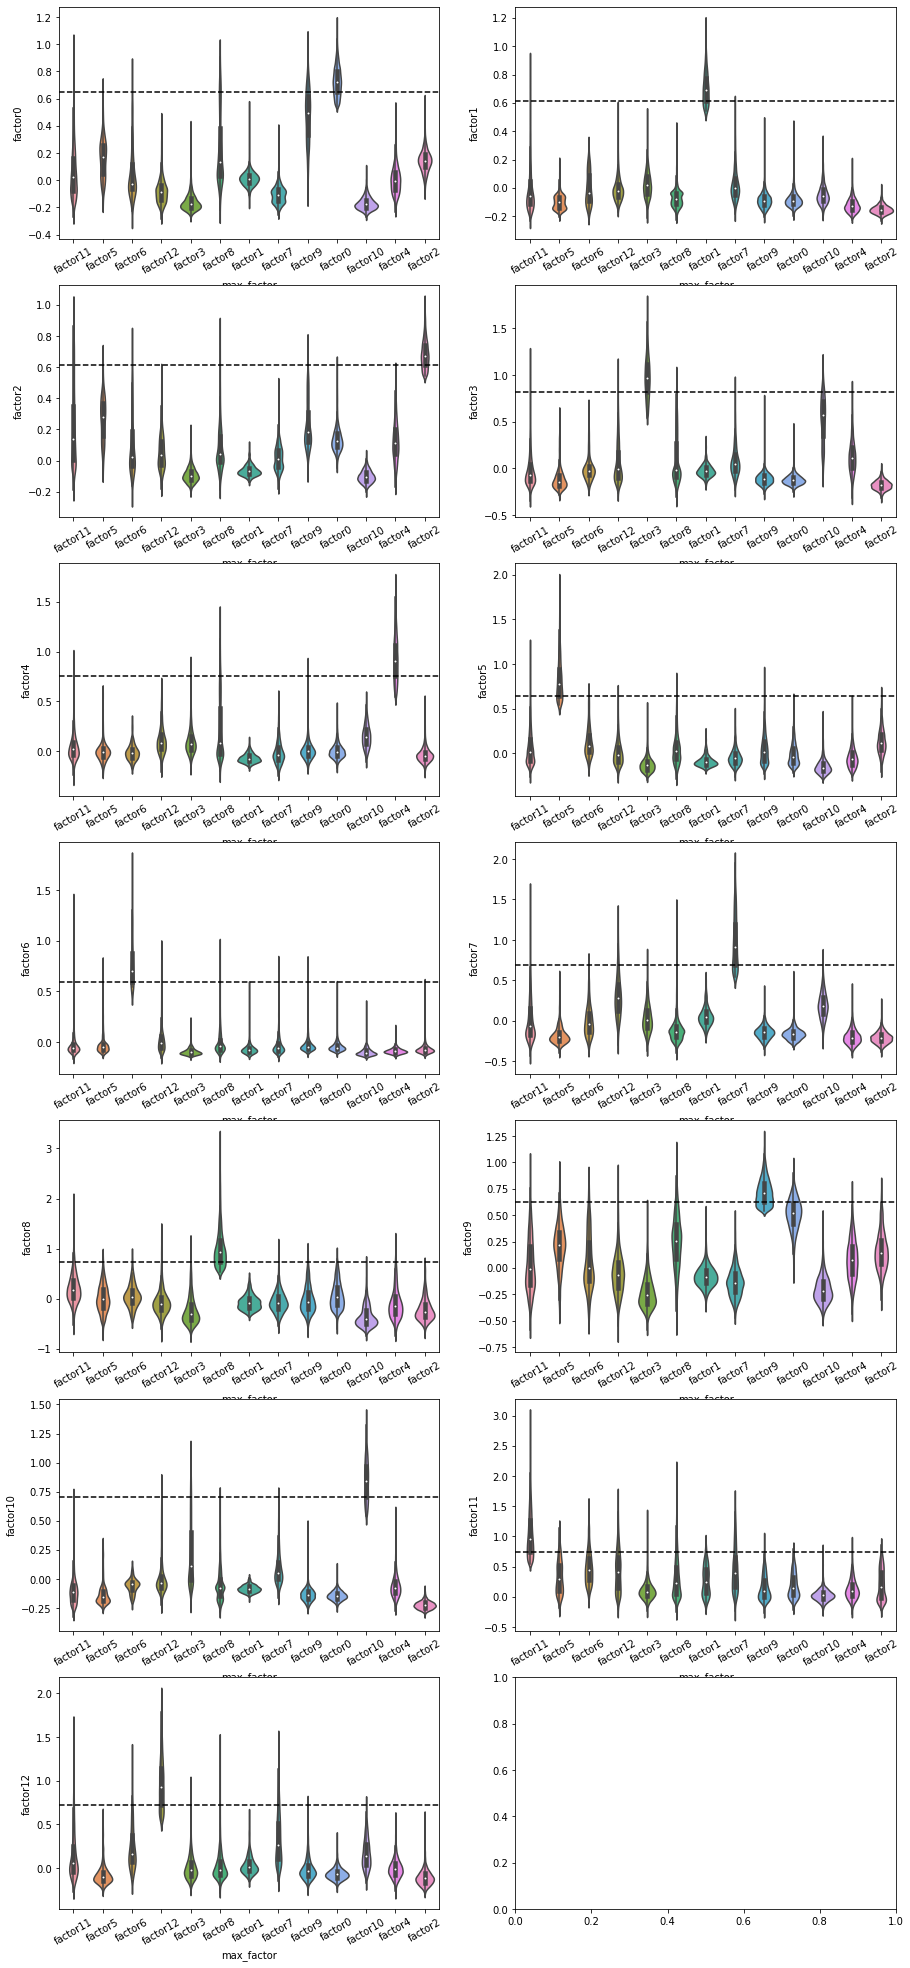

In [4]:
scores, genes_dict = score_modules('Epithelial',nmf_components_by_ctype['Epithelial'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'Epithelial',nmf_components_by_ctype['Epithelial'])

In [5]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 6552 top-scoring cells present in 47 out of 97 samples and 6 datasets

        expected  observed  diff
PCa         4321      2723 -1598
normal      1347      3823  2476
CRPC         883         6  -877
chi2 test p-value: 0.0
 
Top 5 contributing genes:
ACPP
RCAN3
NIPAL3
RDH11
LSAMP
 
************************
 
factor1: 443 top-scoring cells present in 34 out of 97 samples and 6 datasets

        expected  observed  diff
PCa          292       316    24
normal        91       123    32
CRPC          59         4   -55
chi2 test p-value: 7.230274995501856e-15
 
Top 5 contributing genes:
THSD4
NTN4
FLRT3
DST
SLC14A1
 
************************
 
factor2: 2395 top-scoring cells present in 12 out of 97 samples and 3 datasets

        expected  observed  diff
PCa         1579      2387   808
normal       492         8  -484
CRPC         322         0  -322
chi2 test p-value: 6.047259371577425e-264
 
Top 5 contributing genes:
BCAM
HPN
PRAC1
RGS10
SPON2
 
************************
 
fa

In [6]:
# Rename the columns accordingly
replacements = {'factor0':'luminal-like epithelium (normal)','factor1':'basal-like epithelium',
                'factor2':'hallmark cancer epithelium (PCa)','factor3':'basal-like EMT epithelium (CRPC)',
                'factor4':'intermediate epithelium (PCa)','factor5':'intermediate epithelium (PCa)',
                'factor6':'chemokine signalling epithelium','factor7':'intermediate epithelium (normal)',
                'factor8':'metallothionein response epithelium (normal)','factor9':'RAMP1 luminal epithelial (normal)',
                'factor10':'intermediate epithelium (CRPC)','factor11':'stress response epithelium (PCa)',
                    'factor12':'interferon signaling epithelium (CRPC)'}

for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

### T cell

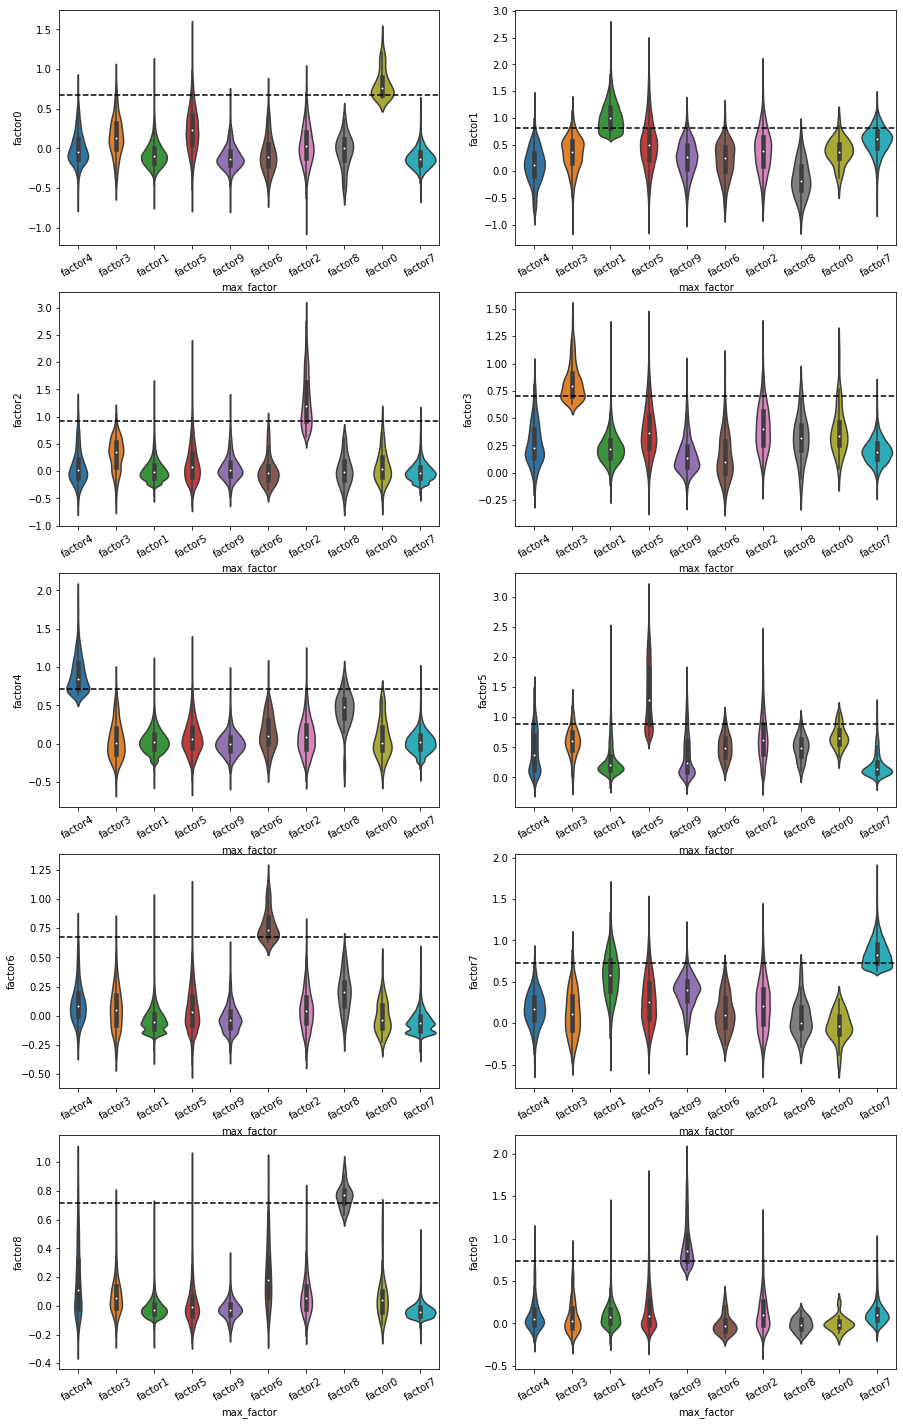

In [7]:
scores, genes_dict = score_modules('T_cell',nmf_components_by_ctype['T_cell'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'T_cell',nmf_components_by_ctype['T_cell'])

In [8]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 56 top-scoring cells present in 13 out of 96 samples and 6 datasets

        expected  observed  diff
PCa           28        41    13
normal        25         5   -20
CRPC           1        10     9
chi2 test p-value: 5.301305841224107e-14
 
Top 5 contributing genes:
SOCS3
H2AFX
CCR7
EEF1A1
MARCKSL1
 
************************
 
factor1: 40043 top-scoring cells present in 87 out of 96 samples and 7 datasets

        expected  observed  diff
PCa        20547     16648 -3899
normal     18255     23165  4910
CRPC        1240       230 -1010
chi2 test p-value: 0.0
 
Top 5 contributing genes:
CXCR4
JUNB
DDIT4
TUBB2A
IFNGR1
 
************************
 
factor2: 2920 top-scoring cells present in 58 out of 96 samples and 7 datasets

        expected  observed  diff
PCa         1498      2156   658
normal      1331       685  -646
CRPC          90        79   -11
chi2 test p-value: 7.605060760785399e-132
 
Top 5 contributing genes:
MT2A
MT1X
MT1E
MT1F
DKK3
 
************************
 

In [9]:
# Rename the columns accordingly
replacements = {'factor0':'drop','factor1':'CD8 T cells (normal)',
                'factor2':'metallothionein T cells (PCa)','factor3':'mature helper T cells',
                    'factor4':'cycling T cells','factor5':'stressed T cells',
                    'factor6':'drop','factor7':'effector T cells (normal)',
                    'factor8':'drop','factor9':'NK T cells'}

for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

### Myeloid

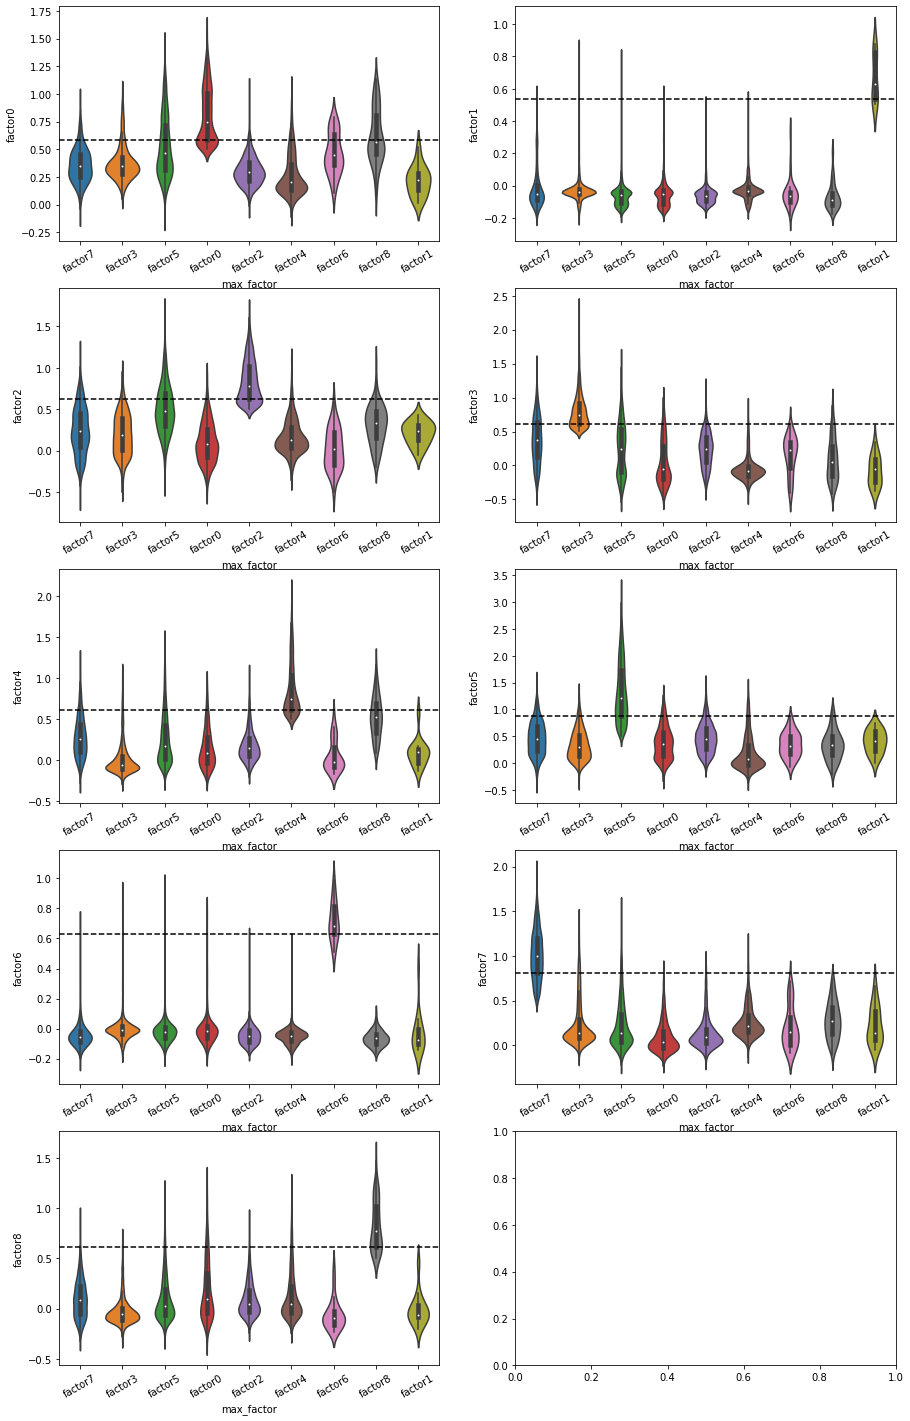

In [10]:
scores, genes_dict = score_modules('Myeloid',nmf_components_by_ctype['Myeloid'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'Myeloid',nmf_components_by_ctype['Myeloid'])

In [11]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 1833 top-scoring cells present in 89 out of 98 samples and 7 datasets

        expected  observed  diff
PCa         1193      1051  -142
normal       484       685   201
CRPC         155        97   -58
chi2 test p-value: 2.5502184562913584e-27
 
Top 5 contributing genes:
HLA-DQA1
ACTB
HLA-DQB1
CNN2
IL2RG
 
************************
 
factor1: 15 top-scoring cells present in 8 out of 98 samples and 4 datasets

        expected  observed  diff
PCa            9        14     5
normal         3         1    -2
CRPC           1         0    -1
chi2 test p-value: 0.06993035859460237
 
Top 5 contributing genes:
KLK2
FXYD3
KRT8
CLDN4
SPON2
 
************************
 
factor2: 2018 top-scoring cells present in 73 out of 98 samples and 7 datasets

        expected  observed  diff
PCa         1313      1511   198
normal       532       494   -38
CRPC         171        13  -158
chi2 test p-value: 1.694561784763406e-39
 
Top 5 contributing genes:
CD83
KLF4
KLF6
SGK1
ZNF331
 
************

In [12]:
# Rename the columns accordingly
replacements = {'factor0':'antigen presenting myeloids (normal)','factor1':'drop',
                    'factor2':'activated AP myeloids (PCa)','factor3':'macrophages (CRPC)',
                    'factor4':'tumor inflammatory monocytes (normal)','factor5':'stressed myeloids (PCa)',
                    'factor6':'drop','factor7':'macrophages 2 (CRPC)',
                    'factor8':'drop'}

for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

### Fibroblasts

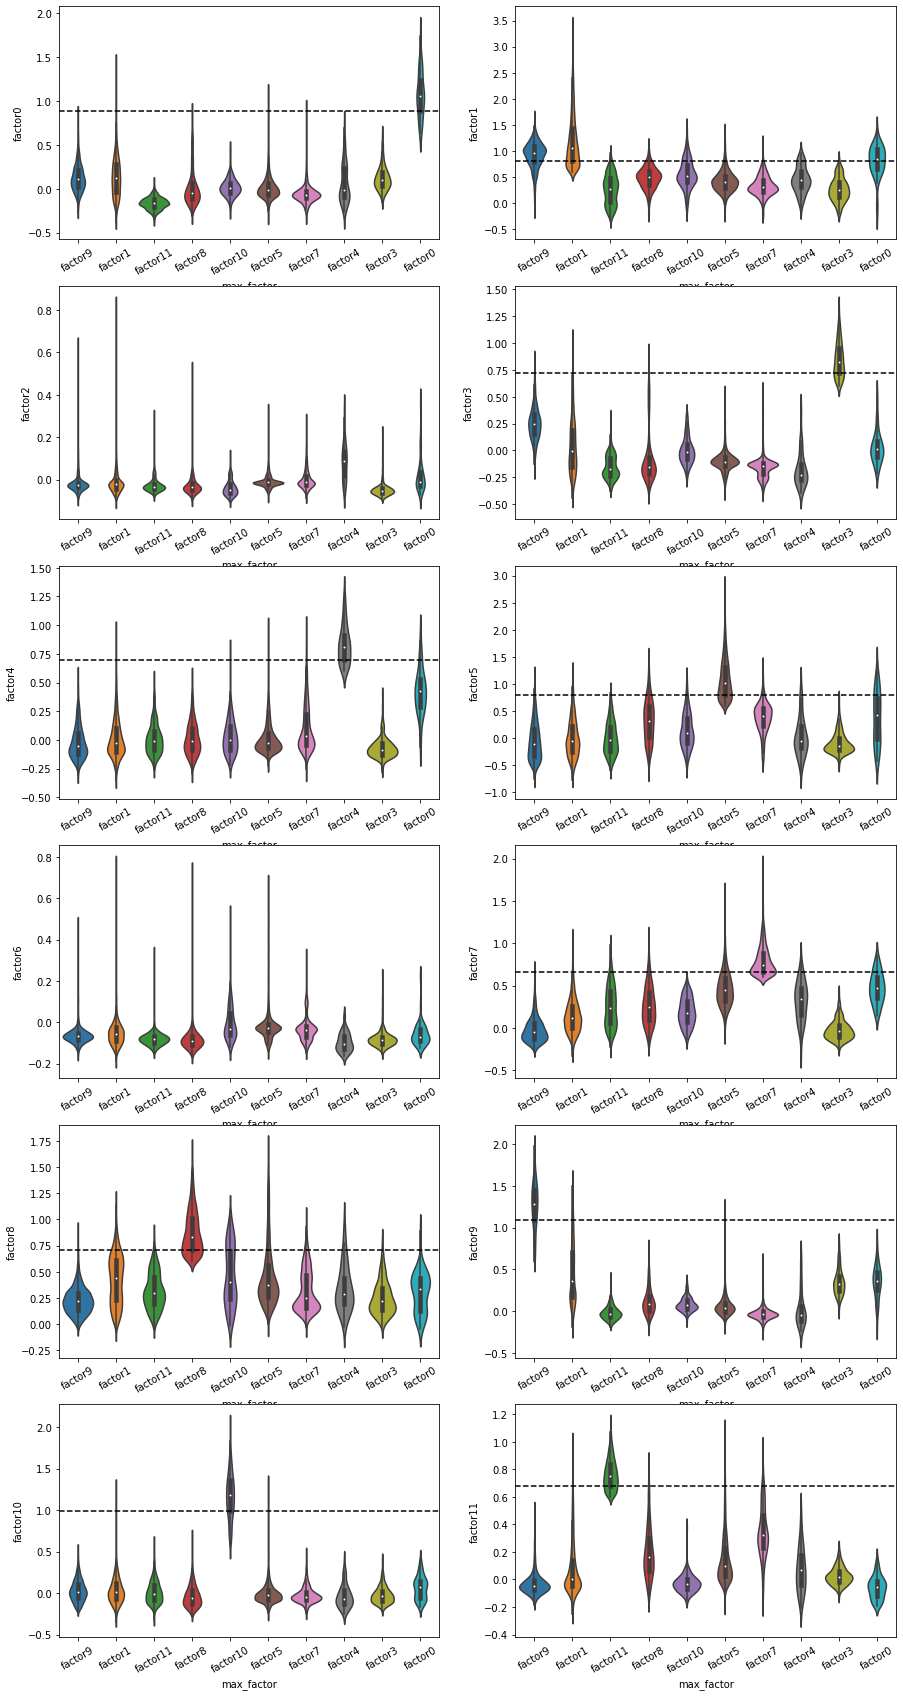

In [13]:
scores, genes_dict = score_modules('Fibroblast_muscle',nmf_components_by_ctype['Fibroblast_muscle'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'Fibroblast_muscle',nmf_components_by_ctype['Fibroblast_muscle'])

In [14]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 67 top-scoring cells present in 12 out of 97 samples and 4 datasets

        expected  observed  diff
PCa           27        28     1
normal        24        38    14
CRPC          14         1   -13
chi2 test p-value: 3.337561978205575e-05
 
Top 5 contributing genes:
PTGDS
SOD2
SAT1
PTN
PLTP
 
************************
 
factor1: 6215 top-scoring cells present in 79 out of 97 samples and 7 datasets

        expected  observed  diff
PCa         2592      1944  -648
normal      2251      1524  -727
CRPC        1371      2747  1376
chi2 test p-value: 0.0
 
Top 5 contributing genes:
RPL37A
TMSB10
ASPSCR1
LGALS1
TIMP1
 
************************
 
factor2: 0 top-scoring cells present in 0 out of 97 samples and 0 datasets

        expected  observed  diff
PCa            0         0     0
normal         0         0     0
CRPC           0         0     0
chi2 test p-value: nan
 
Top 5 contributing genes:
KRT19
KRT15
CLDN4
SYTL1
CD8B
 
************************
 
factor3: 468 top-scorin

In [15]:
# Rename the columns accordingly
replacements = {'factor0':'drop','factor1':'desmoplastic fibroblasts (CRPC)',
                    'factor2':'drop','factor3':'inflammatory fibroblasts (PCa)',
                    'factor4':'drop','factor5':'MYC inflammatory fibroblasts',
                    'factor6':'drop','factor7':'metallothionein fibroblasts (PCa)',
                    'factor8':'stressed fibroblasts (PCa)','factor9':'desmoplastic fibroblasts (normal)',
                    'factor10':'inflammatory fibroblasts (normal)','factor11':'smooth muscle cells (PCa)'}

for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

## Endothelial

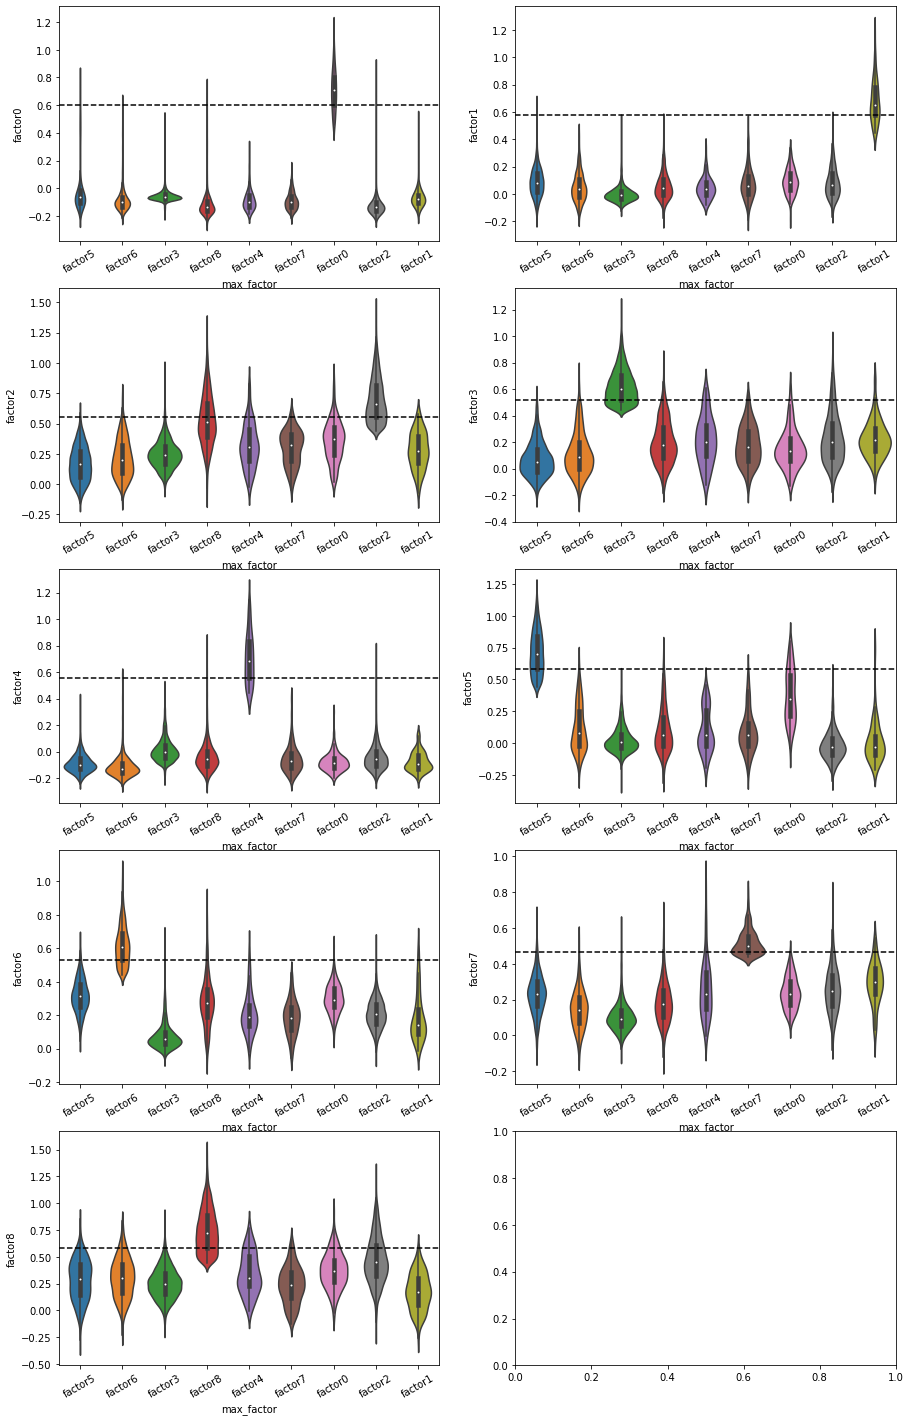

In [16]:
scores, genes_dict = score_modules('Endothelial',nmf_components_by_ctype['Endothelial'])

# remove the first quantile of scores to ensure a representative set
max_factor_scores = scores[list(genes_dict.keys())].max(axis=1)
fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(fitered_scores)
save_dict_to_excel(genes_dict,'Endothelial',nmf_components_by_ctype['Endothelial'])

In [17]:
for f in list(genes_dict.keys()):
    summarize_factor(fitered_scores,f,genes_dict)

factor0: 157 top-scoring cells present in 21 out of 98 samples and 5 datasets

        expected  observed  diff
PCa          100       116    16
normal        48        34   -14
CRPC           7         7     0
chi2 test p-value: 0.030520449824047172
 
Top 5 contributing genes:
TPM2
MYL9
RGS5
CALD1
TAGLN
 
************************
 
factor1: 104 top-scoring cells present in 20 out of 98 samples and 4 datasets

        expected  observed  diff
PCa           66        87    21
normal        32        17   -15
CRPC           5         0    -5
chi2 test p-value: 8.230560630417355e-05
 
Top 5 contributing genes:
KLK2
H2AFJ
KLK3
TSPAN1
FOLH1
 
************************
 
factor2: 4647 top-scoring cells present in 68 out of 98 samples and 7 datasets

        expected  observed  diff
PCa         2970      2866  -104
normal      1440      1350   -90
CRPC         235       431   196
chi2 test p-value: 4.577160706685791e-38
 
Top 5 contributing genes:
ADIRF
CLU
SELE
OLFM1
ZFP36
 
*****************

In [18]:
# Rename the columns accordingly
replacements = {'factor0':'pericytes (PCa)','factor1':'luminal-like endothelial cells (PCa)',
                    'factor2':'stressed endothelial cells (CRPC)','factor3':'metallotheonin/MYC endothelial cells (normal)',
                    'factor4':'drop','factor5':'activated endothelial cells (PCa)',
                    'factor6':'NOTCH signalling endothelial cells (PCa)','factor7':'NPY endothelial cells',
                    'factor8':'endothelial cells (normal)'}

for k in list(replacements.keys()):
    fitered_scores['max_factor'] = fitered_scores['max_factor'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,fitered_scores['max_factor']],axis=0)

## Merging annotations with data

In [19]:
final_annotations = final_annotations.rename(columns={0:'final_annotation'})

In [37]:
adata = sc.read_h5ad('single-cell-reference-subeset-with-broad-annotation.h5ad')
adata.X = adata.layers['counts'].copy()
del adata.layers['counts']

In [38]:
merged_df = pd.merge(adata.obs, final_annotations, left_index=True, right_index=True, how='left')
merged_df['final_annotation'] = merged_df['final_annotation'].fillna(merged_df['refined_celltypes'])

if (merged_df.index == adata.obs.index).all():
    adata.obs = merged_df.copy()
    print('Done')



Done


In [39]:
# Removing the cells with nan as cell type reference
adata = adata[~adata.obs['final_annotation'].isna()]

# Removing factors that were top scorers in less than 100 cells
adata = adata[~(adata.obs['final_annotation']=='drop')]

# Removing cells that scored under the 1st quantile (have their original broad annotation)
adata = adata[~(adata.obs['final_annotation']=='T cell')] # It's named T_cell in the dictionary

for k in list(nmf_components_by_ctype.keys()):
    adata = adata[~(adata.obs['final_annotation']==k)]

In [40]:
# Finished, annotated data
print(adata.obs['final_annotation'].value_counts())
print('')
print('The total number of different celltypes: ' + str(len(adata.obs['final_annotation'].unique())))

CD8 T cells (normal)                             40043
T cell                                           26929
stressed T cells                                 23317
stress response epithelium (PCa)                 18354
B cell                                           13521
effector T cells (normal)                        10753
basal-like EMT epithelium (CRPC)                  9102
Mast                                              7891
stressed myeloids (PCa)                           7608
intermediate epithelium (PCa)                     6705
luminal-like epithelium (normal)                  6552
desmoplastic fibroblasts (CRPC)                   6215
RAMP1 luminal epithelial (normal)                 5071
metallothionein response epithelium (normal)      4759
stressed endothelial cells (CRPC)                 4647
metallotheonin/MYC endothelial cells (normal)     4623
endothelial cells (normal)                        4048
MYC inflammatory fibroblasts                      3416
interferon

In [ ]:
adata.write('./single-cell-reference-with-nmf-derived-annotations-20230608.h5ad')